## Transformer based Model with EfficientNet as Backbone

This model is created to play around with Transformers. The Model is trained on a Kaggle Dataset: https://www.kaggle.com/c/plant-pathology-2021-fgvc8
The problem is to detect if a leaf has one (or multiple) sickness signs, or if it is healthy.

### Deep Learning Model

The Model has a Backbone Model, which takes an image as input and extracts the data. This Model is a pre trained (on ImageNet) EfficientNet model.
The output of this model is further reshaped and by adding positional encoding passed to a Visual Transformer based model.

The model is trained with Adam with weight decay optimizer and uses binary crossentropy as well as tripplet loss to classifly the objects in the image.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers as tfl
import tensorflow_addons as tfa
from tensorflow_addons import layers as tfal
import numpy as np
import pandas as pd
import random
from PIL import Image
import os
from time import time
from datetime import datetime, timedelta
import gc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

Preprocess Data input

In [2]:
import json
with open('config.json', 'r') as f:
    config = json.load(f)
    
img_shape = config["img_shape"]
batch_size = config["batch_size"]
from_logits = config["from_logits"]
learning_rate = config["learning_rate"]
weight_decay = config["weight_decay"]
num_epochs = config["num_epochs"]

In [3]:
record_file = '~/kaggle_datasets/plant-pathology-2021-fgvc8/dataset.tfrecords'
if os.name == 'nt':
    record_file = r"E:\Documents\kaggle_datasets\plant-pathology-2021-fgvc8\dataset.tfrecords"

keys=["healthy", "scab", "frog_eye_leaf_spot", "rust", "complex", "powdery_mildew"]

dataset = tf.data.TFRecordDataset(record_file, buffer_size=100)

# Decoding function
def parse_record(record):
    name_to_features = {
        'label': tf.io.FixedLenFeature([], tf.string),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(record, name_to_features)

def decode_record(record):
    record = parse_record(record)
    image = tf.io.decode_raw(
        record['image_raw'], out_type=np.float32, little_endian=True, fixed_length=None, name=None
    )
    label = tf.io.decode_raw(
        record['label'], out_type=np.float32, little_endian=True, fixed_length=None, name=None
    )
    image = tf.reshape(image, (img_shape, img_shape, 3))
    return (image, label)

dataset = dataset.map(decode_record, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(batch_size).batch(batch_size)

steps_per_epoch_test = 1000//batch_size + 1
test_dataset = dataset.take(steps_per_epoch_test).prefetch(tf.data.AUTOTUNE)
train_dataset = dataset.skip(steps_per_epoch_test).shuffle(batch_size).prefetch(tf.data.AUTOTUNE)

steps_per_epoch_train = 0

Create Model

In [4]:
def create_model():
    inp = tf.keras.Input(shape=(img_shape, img_shape, 3))
    en = tf.keras.applications.EfficientNetB1(include_top=False, input_shape=(img_shape, img_shape, 3))
    en.trainable = False
    x = en(inp)
    x = tfl.Conv2D(64, 3, padding="same")(x)
    x = tfl.Flatten()(x)
    latent_vector = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    x = tfl.Dense(len(keys), kernel_regularizer='l1_l2')(x)
    if not from_logits:
        x = tf.keras.activations.sigmoid(x)
    return tf.keras.Model(inp, [x, latent_vector])
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb1 (Functional)     (None, 8, 8, 1280)   6575239     input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 64)     737344      efficientnetb1[0][0]             
__________________________________________________________________________________________________
flatten (Flatten)               (None, 4096)         0           conv2d[0][0]                     
______________________________________________________________________________________________

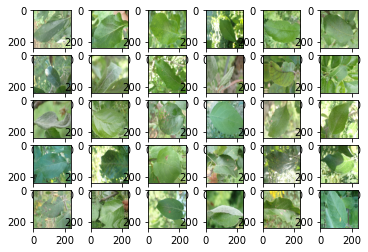

In [5]:
data_augmentation = tf.keras.Sequential(
    [
        tfl.experimental.preprocessing.RandomFlip("horizontal"),
        tfl.experimental.preprocessing.RandomFlip("vertical"),
        tfl.experimental.preprocessing.RandomRotation(factor=0.02),
        tfl.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

site_x = int(np.floor(np.sqrt(batch_size)))
site_y = int(np.ceil(np.sqrt(batch_size)))
fig, axs = plt.subplots(site_x, site_y)
for x in test_dataset:
    imgs = data_augmentation(x[0])
    for i in range(site_x):
        for j in range(site_y):
            if site_x > 1:
                axs[i, j].imshow(imgs[i*site_y+j])
            else:
                axs[j].imshow(imgs[j])
    break

In [6]:
sample_weight_dataset = tf.convert_to_tensor([[0.72761678, 0.58902311, 0.77309283, 1.61988445, 1.56415621, 2.64712825]])
sample_weight_dataset = sample_weight_dataset / tf.reduce_sum(sample_weight_dataset)*0.5+0.5
sample_weight_dataset = sample_weight_dataset / tf.reduce_mean(sample_weight_dataset)
accuracy_mult = 2**tf.range(len(keys))[None, :]
class_index_mul = tf.cast(accuracy_mult, tf.float32)
    
loss_binary_crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=from_logits)
loss_triplet = tfa.losses.TripletSemiHardLoss()
loss_mse = tf.keras.losses.MSE

def compute_loss(labels, predictions, lambda_mse=0.0, lambda_bce=1.0, lambda_triplet=1.0):
    if from_logits:
        lmse = lambda_mse*loss_mse(labels, tf.keras.activations.sigmoid(predictions[0]))
    else:
        lmse = lambda_mse*loss_mse(labels, predictions[0])
    lbce = lambda_bce*loss_binary_crossentropy(labels, predictions[0])
    lt = lambda_triplet*loss_triplet(tf.reduce_sum(labels * class_index_mul, -1), predictions[1])
    return lmse + lbce + lt, lmse, lbce, lt

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
train_mse_loss = tf.keras.metrics.Mean(name='train_mse_loss')
train_bce_loss = tf.keras.metrics.Mean(name='train_bce_loss')
train_triplet_loss = tf.keras.metrics.Mean(name='train_triplet_loss')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
test_mse_loss = tf.keras.metrics.Mean(name='test_mse_loss')
test_bce_loss = tf.keras.metrics.Mean(name='test_bce_loss')
test_triplet_loss = tf.keras.metrics.Mean(name='test_triplet_loss')

losses = [train_loss, train_accuracy, train_mse_loss, train_bce_loss, train_triplet_loss, test_loss, test_accuracy, test_mse_loss, test_bce_loss, test_triplet_loss]

def reset_metrics():
    for l in losses:
        l.reset_states()

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, clipnorm=1.0)

def update_metrics(labels, predictions, loss, loss_metric, accuracy_metric, lmse, mse_metric, lbce, bce_metrix, lt, triplet_metric):
    loss_metric.update_state(loss)
    labels_new = tf.reduce_sum(tf.cast(labels > 0.5, tf.int32) * accuracy_mult, -1)[:, None]
    predictions_new = tf.reduce_sum(tf.cast(predictions > (0 if from_logits else 0.5), tf.int32) * accuracy_mult, -1)[:, None]
    accuracy_metric.update_state(labels_new, predictions_new)
    mse_metric.update_state(lmse)
    bce_metrix.update_state(lbce)
    triplet_metric.update_state(lt)
    gc.collect()
    tf.keras.backend.clear_session()

def train_step(inputs):
    images, labels = inputs

    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss, lmse, lbce, lt = compute_loss(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    update_metrics(labels, predictions[0], loss, train_loss, train_accuracy, lmse, train_mse_loss, lbce, train_bce_loss, lt, train_triplet_loss)

def test_step(inputs):
    images, labels = inputs
    predictions = model(images, training=False)
    loss, lmse, lbce, lt = compute_loss(labels, predictions)
    update_metrics(labels, predictions[0], loss, test_loss, test_accuracy, lmse, test_mse_loss, lbce, test_bce_loss, lt, test_triplet_loss)
    

In [7]:
template = ("Epoch {}/{} [{}{}{}] {}/{} ETA: {}, Loss: {:0.5f}, Accuracy: {:0.5f}, Test Loss: {:0.5f}, Test Accuracy: {:0.5f} - MSE: {:0.5f}, BCE: {:0.5f}, TRI: {:0.5f},  TMSE: {:0.5f}, TBCE: {:0.5f}, TTRI: {:0.5f}")

def print_status(epoch, i, steps_per_epoch, start):
    delta = steps_per_epoch/i*(time() - start)
    end = datetime.fromtimestamp(start) + timedelta(seconds=delta)
    percent = int(i/steps_per_epoch*100)
    print(" "*200, end="\r")
    print(template.format(epoch+1,
                          num_epochs,
                          "="*(percent//2),
                          ">" if percent < 100 else "",
                          " "*(49 - percent//2),
                          i,
                          steps_per_epoch,
                          end.strftime('%d/%m/%y, %H:%M:%S'),
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100,
                          train_mse_loss.result(),
                          train_bce_loss.result(),
                          train_triplet_loss.result(),
                          test_mse_loss.result(),
                          test_bce_loss.result(),
                          test_triplet_loss.result()),
                          end="\r")

In [8]:
class ReduceLR:
    def __init__(self, optimizer, monitor, factor=0.1, patience=10, min_delta=0.0001, cooldown=0, min_lr=0.0000001):
        self.optimizer = optimizer
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.cooldown = cooldown
        self.cooldown_counter  = 0
        self.min_lr = min_lr
        self.wait = 0
        if "acc" not in monitor.name:
            self.monitor_op = lambda a, b: np.less(a, b - min_delta)
            self.best = np.Inf
        else:
            self.monitor_op = lambda a, b: np.greater(a, b + min_delta)
            self.best = -np.Inf
        
    def __call__(self):
        if self.in_cooldown():
            self.cooldown_counter -= 1
            self.wait = 0

        if self.monitor_op(self.monitor.result(), self.best):
            self.best = self.monitor.result()
            self.wait = 0
        elif not self.in_cooldown():
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(self.optimizer.lr.read_value())
                if old_lr > self.min_lr:
                    new_lr = old_lr * self.factor
                    new_lr = max(new_lr, self.min_lr)
                    self.optimizer.lr.assign(new_lr)
                    self.cooldown_counter = self.cooldown
                    self.wait = 0

    def in_cooldown(self):
        return self.cooldown_counter > 0
    
class SaveWeights:
    def __init__(self, optimizer, model, monitor, checkpoint_filepath="./tmp/checkpoint", min_delta=0.0001):
        self.checkpoint_filepath = checkpoint_filepath
        self.checkpoint_prefix = os.path.join(checkpoint_filepath, "ckpt")
        self.checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
        self.monitor = monitor
        self.model = model
        if "acc" not in monitor.name:
            self.monitor_op = lambda a, b: np.less(a, b - min_delta)
            self.best = np.Inf
        else:
            self.monitor_op = lambda a, b: np.greater(a, b + min_delta)
            self.best = -np.Inf
            
    def __call__(self):
        if self.monitor_op(self.monitor.result(), self.best):
            self.best = self.monitor.result()
            self.checkpoint.save(self.checkpoint_prefix)
            
    def restore_best(self):
        self.checkpoint.restore(tf.train.latest_checkpoint(self.checkpoint_filepath))
        
    def save_model(self):
        self.model.save('model/my_model')
        
    def save_best(self):
        self.restore_best()
        self.save_model()

reduce_lr = ReduceLR(optimizer, test_loss, min_delta=0, patience=5)
save_weights = SaveWeights(optimizer, model, test_loss)
callbacks = [save_weights]

In [9]:
def fit(train_dataset, test_dataset, num_epochs, steps_per_epoch_train, steps_per_epoch_test,  *, start_epoch=0, callbacks=[]):
    cb = callbacks + [reset_metrics, print]
    for epoch in range(start_epoch, num_epochs):
        start = time()
        update_spe_train = steps_per_epoch_train == 0
        for i, x in enumerate(train_dataset):
            train_step((data_augmentation(x[0]), x[1]))
            if update_spe_train:
                steps_per_epoch_train += 1
            print_status(epoch, i+1, steps_per_epoch_train, start)
        # TEST LOOP
        start = time()
        for i, x in enumerate(test_dataset):
            test_step(x)
            print_status(epoch, i+1, steps_per_epoch_test, start)
        for c in cb:
            c()

In [10]:
fit(train_dataset, test_dataset, num_epochs//10, steps_per_epoch_train, steps_per_epoch_test, callbacks=callbacks)

Epoch 1/100 [==================================================] 32/32 ETA: 27/05/21, 00:27:59, Loss: 1.40942, Accuracy: 1.61858, Test Loss: 1.46693, Test Accuracy: 0.00000 - MSE: 0.00000, BCE: 0.46785, TRI: 0.94138,  TMSE: 0.00000, TBCE: 0.46761, TTRI: 0.9993200
Epoch 2/100 [==================================================] 32/32 ETA: 27/05/21, 00:39:23, Loss: 1.39528, Accuracy: 1.33462, Test Loss: 1.47601, Test Accuracy: 0.00000 - MSE: 0.00000, BCE: 0.46209, TRI: 0.93340,  TMSE: 0.00000, TBCE: 0.47800, TTRI: 0.9980100
Epoch 3/100 [==================================================] 32/32 ETA: 27/05/21, 00:50:49, Loss: 1.39147, Accuracy: 0.28396, Test Loss: 1.46577, Test Accuracy: 0.00000 - MSE: 0.00000, BCE: 0.46157, TRI: 0.92992,  TMSE: 0.00000, TBCE: 0.46662, TTRI: 0.9991500
Epoch 4/100 [==================================================] 32/32 ETA: 27/05/21, 01:02:16, Loss: 1.38629, Accuracy: 0.57928, Test Loss: 1.46235, Test Accuracy: 0.00000 - MSE: 0.00000, BCE: 0.45711, TRI: 

In [11]:
model.trainable=True
save_weights.restore_best()
callbacks = [reduce_lr, save_weights]
fit(train_dataset, test_dataset, num_epochs//10*2, steps_per_epoch_train, steps_per_epoch_test, callbacks=callbacks, start_epoch=num_epochs//10)

Epoch 11/100 [==================================================] 32/32 ETA: 27/05/21, 02:22:22, Loss: 0.77402, Accuracy: 70.13857, Test Loss: 2.07359, Test Accuracy: 22.85156 - MSE: 0.00000, BCE: 0.19853, TRI: 0.57545,  TMSE: 0.00000, TBCE: 1.09196, TTRI: 0.981630
Epoch 12/100 [==================================================] 32/32 ETA: 27/05/21, 02:33:59, Loss: 0.48039, Accuracy: 81.58224, Test Loss: 1.53473, Test Accuracy: 24.12109 - MSE: 0.00000, BCE: 0.13126, TRI: 0.34962,  TMSE: 0.00000, TBCE: 0.56882, TTRI: 0.965910
Epoch 13/100 [==================================================] 32/32 ETA: 27/05/21, 02:45:33, Loss: 0.41119, Accuracy: 83.83121, Test Loss: 0.77362, Test Accuracy: 76.26953 - MSE: 0.00000, BCE: 0.11637, TRI: 0.29510,  TMSE: 0.00000, TBCE: 0.18115, TTRI: 0.592470
Epoch 14/100 [==================================================] 32/32 ETA: 27/05/21, 02:57:13, Loss: 0.37068, Accuracy: 85.34189, Test Loss: 1.42484, Test Accuracy: 13.76953 - MSE: 0.00000, BCE: 0.104

In [12]:
save_weights.restore_best()
start = time()
for i, x in enumerate(test_dataset):
    test_step(x)
    print_status(0, i+1, steps_per_epoch_test, start)
reset_metrics()

In [13]:
def create_w_vit(inp, x, num_heads = 4, transformer_layers = 8, mlp_head_units = [2048, 1024]):

    def mlp(x, hidden_units, dropout_rate):
        for units in hidden_units:
            x = tfl.Dense(units, activation=tf.nn.gelu)(x)
            x = tfl.Dropout(dropout_rate)(x)
        return x

    class PositionalEncoding(tfl.Layer):
        def __init__(self, num_patches, projection_dim):
            super(PositionalEncoding, self).__init__()
            self.projection = tfl.Dense(units=projection_dim)
            self.position_embedding = tfl.Embedding(input_dim=num_patches, output_dim=projection_dim)
            self.positions = tf.range(start=0, limit=num_patches, delta=1)
            

        def call(self, inputs):
            return self.projection(inputs) + self.position_embedding(self.positions)

    x = tfl.Reshape((-1, x.shape[3]))(x)
    projection_dim = x.shape[-1]
    num_patches = x.shape[-2]
    x = PositionalEncoding(num_patches, projection_dim)(x)
    transformer_units = [
        projection_dim * 2,
        projection_dim,
    ]

    for _ in range(transformer_layers):
            x1 = tfl.LayerNormalization(epsilon=1e-6)(x)
            attention_output = tfl.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
            x2 = tfl.Add()([attention_output, x])
            x3 = tfl.LayerNormalization(epsilon=1e-6)(x2)
            x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
            x = tfl.Add()([x3, x2])

    x = tfl.LayerNormalization(epsilon=1e-6)(x)
    x = tfl.Flatten()(x)
    x = tfl.Dropout(0.5)(x)
    x = mlp(x, hidden_units=mlp_head_units, dropout_rate=0.5)
    latent_vector = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    x = tfl.Dense(len(keys))(x)
    if not from_logits:
        x = tf.keras.activations.sigmoid(x)
    return tf.keras.Model(inp, (x, latent_vector))

model.trainable = False
model = create_w_vit(model.input, model.layers[-4].output, num_heads=len(keys), transformer_layers=3, mlp_head_units=[256, 128])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb1 (Functional)     (None, 8, 8, 1280)   6575239     input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 64)     737344      efficientnetb1[0][0]             
__________________________________________________________________________________________________
reshape (Reshape)               (None, 64, 64)       0           conv2d[0][0]                     
______________________________________________________________________________________________

In [14]:
reduce_lr = ReduceLR(optimizer, test_loss, min_delta=0, patience=5)
save_weights = SaveWeights(optimizer, model, test_loss, checkpoint_filepath='./tmp/checkpoint_vit')
callbacks = [reduce_lr, save_weights]
fit(train_dataset, test_dataset, num_epochs//10*3, steps_per_epoch_train, steps_per_epoch_test, callbacks=callbacks, start_epoch=num_epochs//10*2)

Epoch 21/100 [==================================================] 32/32 ETA: 27/05/21, 04:19:29, Loss: 1.23019, Accuracy: 56.61063, Test Loss: 0.44023, Test Accuracy: 86.91406 - MSE: 0.00000, BCE: 0.29438, TRI: 0.93577,  TMSE: 0.00000, TBCE: 0.13190, TTRI: 0.308340
Epoch 22/100 [==================================================] 32/32 ETA: 27/05/21, 04:31:01, Loss: 1.05982, Accuracy: 72.22285, Test Loss: 0.43741, Test Accuracy: 87.50000 - MSE: 0.00000, BCE: 0.18053, TRI: 0.87895,  TMSE: 0.00000, TBCE: 0.13892, TTRI: 0.298490
Epoch 23/100 [==================================================] 32/32 ETA: 27/05/21, 04:42:31, Loss: 1.01378, Accuracy: 74.93753, Test Loss: 0.40257, Test Accuracy: 87.50000 - MSE: 0.00000, BCE: 0.16574, TRI: 0.84805,  TMSE: 0.00000, TBCE: 0.13911, TTRI: 0.263460
Epoch 24/100 [==================================================] 32/32 ETA: 27/05/21, 04:54:00, Loss: 0.98155, Accuracy: 76.65834, Test Loss: 0.42492, Test Accuracy: 87.10938 - MSE: 0.00000, BCE: 0.159

In [15]:
save_weights.restore_best()
model.trainable = True
fit(train_dataset, test_dataset, num_epochs, steps_per_epoch_train, steps_per_epoch_test, callbacks=callbacks, start_epoch=num_epochs//10*3)

Epoch 31/100 [==================================================] 32/32 ETA: 27/05/21, 06:14:40, Loss: 0.91620, Accuracy: 79.94093, Test Loss: 0.58758, Test Accuracy: 84.76562 - MSE: 0.00000, BCE: 0.14704, TRI: 0.76928,  TMSE: 0.00000, TBCE: 0.19340, TTRI: 0.394180
Epoch 32/100 [==================================================] 32/32 ETA: 27/05/21, 06:26:21, Loss: 0.90744, Accuracy: 80.00340, Test Loss: 0.40942, Test Accuracy: 86.42578 - MSE: 0.00000, BCE: 0.14250, TRI: 0.76485,  TMSE: 0.00000, TBCE: 0.13419, TTRI: 0.275230
Epoch 33/100 [==================================================] 32/32 ETA: 27/05/21, 06:38:01, Loss: 0.89978, Accuracy: 80.30441, Test Loss: 0.45035, Test Accuracy: 86.03516 - MSE: 0.00000, BCE: 0.13742, TRI: 0.76309,  TMSE: 0.00000, TBCE: 0.13610, TTRI: 0.314250
Epoch 34/100 [==================================================] 32/32 ETA: 27/05/21, 06:49:50, Loss: 0.89620, Accuracy: 80.39528, Test Loss: 0.43373, Test Accuracy: 85.44922 - MSE: 0.00000, BCE: 0.139

KeyboardInterrupt: 

In [16]:
save_weights.restore_best()
start = time()
for i, x in enumerate(test_dataset):
    test_step(x)
    print_status(0, i+1, steps_per_epoch_test, start)
reset_metrics()

In [ ]:
tf.keras.Model(model.input, model.output[0]).save('model/my_model')